In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

In [2]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.utils import np_utils

Using TensorFlow backend.
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Admin\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

In [3]:
def feature_normalize(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.std(dataset, axis=0)
    return (dataset - mu)/sigma

In [4]:
def show_basic_dataframe_info(dataframe,
                              preview_rows=20):

    """
    This function shows basic information for the given dataframe
    Args:
        dataframe: A Pandas DataFrame expected to contain data
        preview_rows: An integer value of how many rows to preview
    Returns:
        Nothing
    """

    # Shape and how many rows and columns
    print("Number of columns in the dataframe: %i" % (dataframe.shape[1]))
    print("Number of rows in the dataframe: %i\n" % (dataframe.shape[0]))
    print("First 20 rows of the dataframe:\n")
    # Show first 20 rows
    print(dataframe.head(preview_rows))
    print("\nDescription of dataframe:\n")
    # Describe dataset like mean, min, max, etc.
    # print(dataframe.describe())

In [5]:
def read_data(file_path):

    """
    This function reads the accelerometer data from a file
    Args:
        file_path: URL pointing to the CSV file
    Returns:
        A pandas dataframe
    """
    data = np.load(file_path)
    column_names = ['x-axis',
                    'y-axis',
                    'labels']
    df = pd.DataFrame(data, columns=column_names)

    return df

In [6]:
def plot_axis(ax, x, y, title):

    ax.plot(x, y)
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

In [8]:
def create_segments_and_labels(df, time_steps, step, label_name):

    """
    This function receives a dataframe and returns the reshaped segments
    of x,y acceleration as well as the corresponding labels
    Args:
        df: Dataframe in the expected format
        time_steps: Integer value of the length of a segment that is created
    Returns:
        reshaped_segments
        labels:
    """

    # x, y acceleration as features
    N_FEATURES = 2
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    l = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments = np.dstack((xs, ys))
        l.append(segments)
        #print(segments.shape)
        labels.append(label)
        #break
    

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(l, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    #print(reshaped_segments.shape)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [9]:
LABELS = ["bhujangasan",
          "padamasan",
          "shavasan",
          "tadasan",
          "trikonasan",
          "vrikshasan"]

In [10]:
TIME_PERIODS = 25

In [11]:
STEP_DISTANCE = 25

In [12]:
df_train = read_data('data_files/combined_xylabel/data_train_xylabel.npy')

In [13]:
df_train.head()

,x-axis,y-axis,labels
0,872.200,606.643,0.0
1,826.190,585.765,0.0
2,828.213,600.433,0.0
3,759.296,619.278,0.0
4,694.428,625.447,0.0


In [14]:
df_test = read_data('data_files/combined_xylabel/data_test_xylabel.npy')

In [15]:
df_val = read_data('data_files/combined_xylabel/data_val_xylabel.npy')

In [16]:
LABEL = 'labels'

In [17]:
df_train['x-axis'] = feature_normalize(df_train['x-axis'])
df_test['x-axis'] = feature_normalize(df_test['x-axis'])
df_val['x-axis'] = feature_normalize(df_val['x-axis'])

df_train['y-axis'] = feature_normalize(df_train['y-axis'])
df_test['y-axis'] = feature_normalize(df_test['y-axis'])
df_val['y-axis'] = feature_normalize(df_val['y-axis'])

In [18]:
X_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [19]:
X_train.shape

(69919, 25, 2)

In [25]:
X_test, y_test = create_segments_and_labels(df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [26]:
X_test.shape

(23313, 25, 2)

In [27]:
y_test.shape

(23313,)

In [28]:
X_val, y_val = create_segments_and_labels(df_val,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [29]:
num_time_periods, num_sensors = X_train.shape[1], X_train.shape[2]

In [30]:
num_classes = 6

In [31]:
y_train.shape

(69919,)

In [32]:
input_shape = (num_time_periods*num_sensors)
X_train = X_train.reshape(X_train.shape[0], input_shape)

In [33]:
X_train = X_train.reshape(X_train.shape[0], input_shape)

In [34]:
print('X_train shape:', X_train.shape)

X_train shape: (69919, 50)


In [35]:
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")

In [36]:
y_train = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train.shape)

New y_train shape:  (69919, 6)


In [37]:
print("\n--- Create neural network model ---\n")


--- Create neural network model ---



In [38]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
print('here1')
model_m.add(Conv1D(100, 10, activation='relu', input_shape=(TIME_PERIODS, num_sensors)))
print('here2')
model_m.add(Conv1D(100, 10, activation='relu'))
print('here3')
model_m.add(MaxPooling1D(3))
print('here4')
model_m.add(Conv1D(160, 10, activation='relu', padding="same"))
print('here5')
model_m.add(Conv1D(160, 10, activation='relu', padding="same"))
print('here6')
model_m.add(GlobalAveragePooling1D())
model_m.add(Dropout(0.5))
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())




here1
Instructions for updating:
Colocations handled automatically by placer.
here2
here3
here4
here5
here6
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 25, 2)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16, 100)           2100      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 100)            100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 2, 100)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 2, 160)            160160    
___________________________________________________

In [39]:
print("\n--- Fit the model ---\n")


--- Fit the model ---



In [41]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_acc:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    #keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

In [42]:
model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [43]:
BATCH_SIZE = 400
EPOCHS = 50

In [44]:
X_val = X_val.reshape(X_val.shape[0], input_shape)

X_val = X_val.astype("float32")
y_val = y_val.astype("float32")

y_val = np_utils.to_categorical(y_val, num_classes)
print('New y_val shape: ', y_val.shape)

New y_val shape:  (23304, 6)


In [45]:
history = model_m.fit(X_train,
                      y_train,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_data=(X_val, y_val),
                      verbose=1)

Instructions for updating:
Use tf.cast instead.
Train on 69919 samples, validate on 23304 samples
Epoch 1/50
69919/69919 [==============================] - 27s 382us/step - loss: 0.1932 - acc: 0.9317 - val_loss: 0.6145 - val_acc: 0.9191
Epoch 2/50
69919/69919 [==============================] - 27s 379us/step - loss: 0.0211 - acc: 0.9938 - val_loss: 0.6878 - val_acc: 0.9231
Epoch 3/50
69919/69919 [==============================] - 25s 362us/step - loss: 0.0134 - acc: 0.9955 - val_loss: 0.6033 - val_acc: 0.9252
Epoch 4/50
69919/69919 [==============================] - 27s 392us/step - loss: 0.0122 - acc: 0.9957 - val_loss: 0.4398 - val_acc: 0.9251
Epoch 5/50
69919/69919 [==============================] - 27s 386us/step - loss: 0.0082 - acc: 0.9968 - val_loss: 0.8431 - val_acc: 0.9137
Epoch 6/50
69919/69919 [==============================] - 27s 385us/step - loss: 0.0073 - acc: 0.9973 - val_loss: 0.8530 - val_acc: 0.9262
Epoch 7/50
69919/69919 [==============================] - 24s 345us/

In [46]:
print("\n--- Learning curve of model training ---\n")


--- Learning curve of model training ---



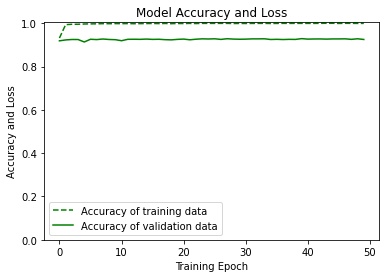

In [47]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], "g--", label="Accuracy of training data")
plt.plot(history.history['val_acc'], "g", label="Accuracy of validation data")
#plt.plot(history.history['loss'], "r--", label="Loss of training data")
#plt.plot(history.history['val_loss'], "r", label="Loss of validation data")
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

In [48]:
model = model_m
#load best weights from current training
model.load_weights("best_model.04-0.93.h5")

In [49]:
X_test = X_test.reshape(X_test.shape[0], input_shape)

In [50]:
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

In [51]:
y_test = np_utils.to_categorical(y_test, num_classes)

In [52]:
y_test.shape

(23313, 6)

In [54]:
score = model.evaluate(X_test, y_test, verbose=1)

23313/23313 [==============================] - 3s 143us/step


In [55]:
print("\nAccuracy on test data: %0.2f" % score[1])
print("\nLoss on test data: %0.2f" % score[0])


Accuracy on test data: 0.87

Loss on test data: 0.63
